In [37]:
%load_ext autoreload
%autoreload 3

In [1]:
HIGH_PERFORMANCE = False
DYNAMO_DEBUG = False
COMPILE = True
SHOW_ANIMATION = True

In [2]:
%env TORCH_LOGS=dynamo 
%env TORCHDYNAMO_VERBOSE=1

env: TORCH_LOGS=dynamo
env: TORCHDYNAMO_VERBOSE=1


In [3]:
import torch
import matplotlib.pyplot as plt
from flipper_training.configs import (
    WorldConfig,
    RobotModelConfig,
    PhysicsEngineConfig,
)
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from copy import deepcopy
from collections import deque

In [4]:
from flipper_training.utils.torch_utils import autodevice

device = autodevice(HIGH_PERFORMANCE)

In [5]:
from flipper_training.vis.static_vis import *

In [6]:
torch.random.manual_seed(420)

In [7]:
num_robots = 1

In [8]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing="xy")

In [9]:
# # gaussian hm
# z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
#      0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
#      2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
#      ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
# block hm
z = torch.zeros_like(x)
for thresh in [1.0, 0, -1.0, -2]:
    z[torch.logical_and(x > -thresh, y < thresh)] += 0.3
# quadratic hill hm
# z = 1 - 0.01 * ((x-1)**8 + (y+3)**8) + 0.01 * torch.randn_like(x)
# z.clamp_(min=0)
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1, 128, 128])

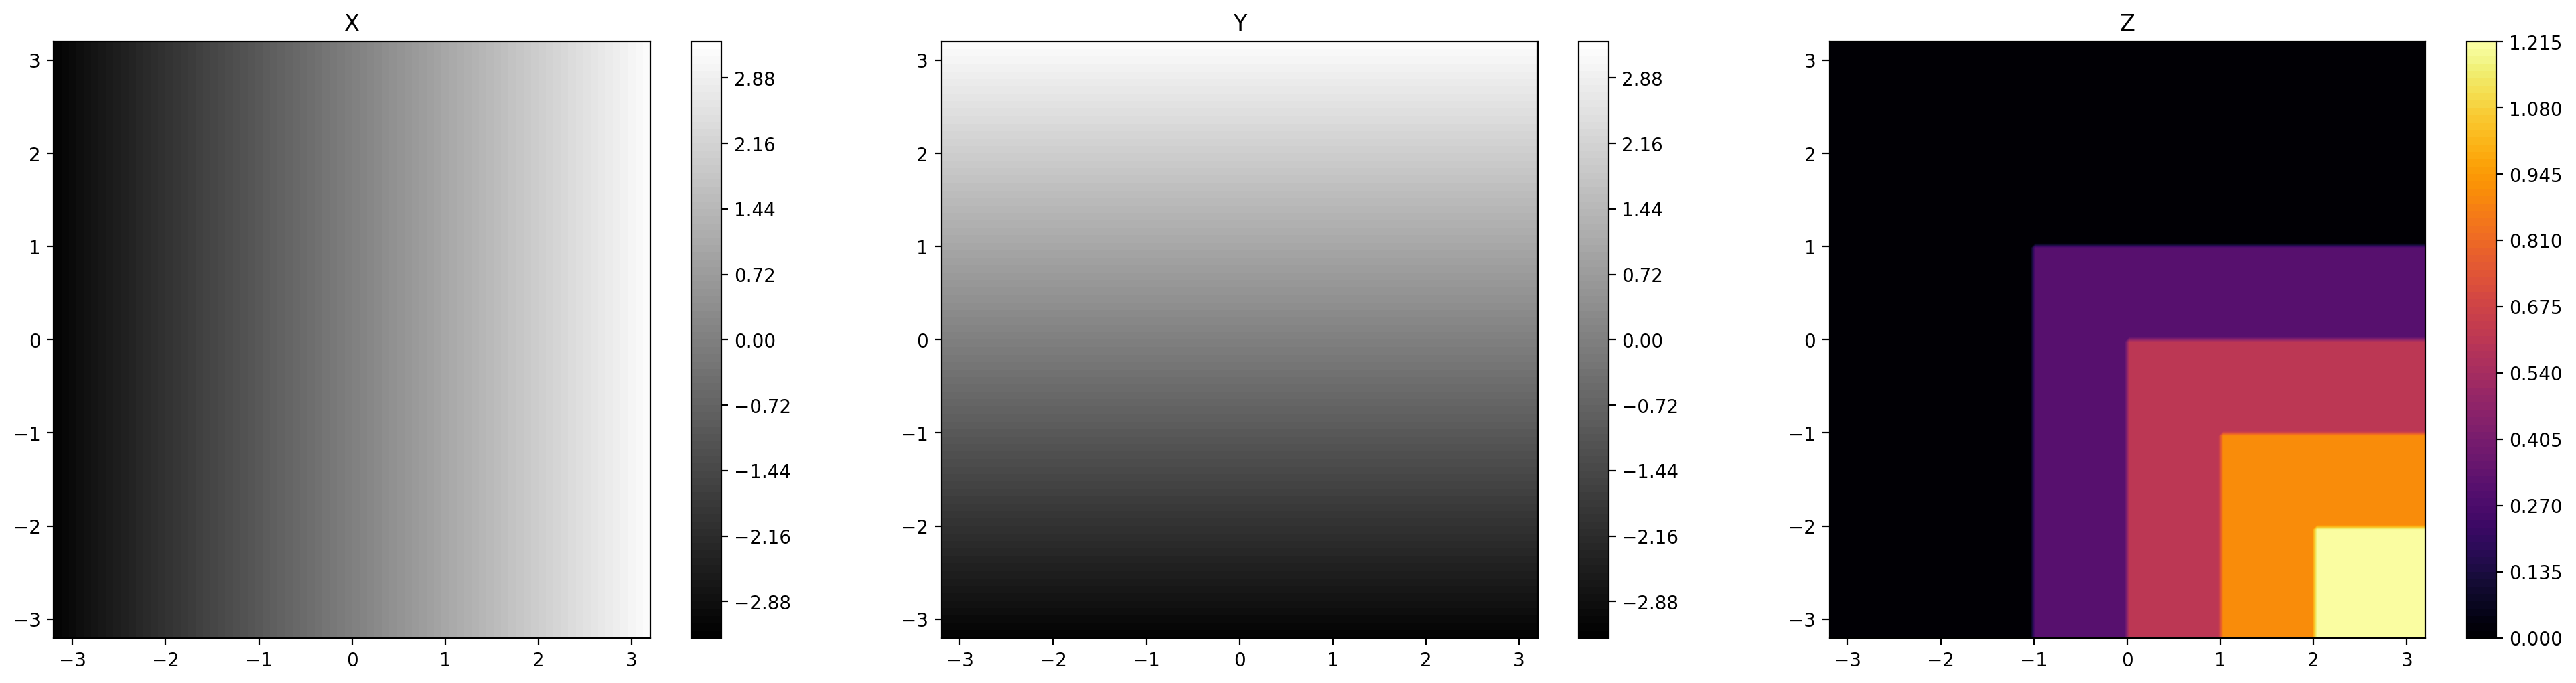

In [10]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [11]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv")
world_config = WorldConfig(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=20000,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.010_192_bv0.01_whl0.02_trck0.05.pt
driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_movable_mask: torch.Size([4])
driving_part_points: torch.Size([4, 192, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([256, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 192, 3])
joint_local_driving_part_pts: torch.Size([4, 192, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])
RobotModelConfig for marv
Body mass: 47.8
Total mass: 67.8
Body bbox: tensor([ 0.3000,  0.1900,  0.4500, -0.3000, -0.1900, -0.0500])
Number of driving parts: 4
Driving part masses: tensor([5., 5.,

In [12]:
# Controls
traj_length = 7.5  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = 0.0  # rad/s yaw
controls = robot_model.vw_to_vels(speed, omega)
flipper_controls = torch.zeros_like(controls)

In [13]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.to(device)

In [14]:
engine = DPhysicsEngine(physics_config, robot_model, device)

In [38]:
from flipper_training.utils.geometry import unit_quaternion


x0 = torch.tensor([-3, -2.5, 3.2]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
q0 = unit_quaternion(num_robots, device=device)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, robot_model.num_driving_parts).to(device)
controls_all = torch.cat((controls, flipper_controls), dim=-1).repeat(n_iters, num_robots, 1).to(device)

In [39]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = 0.0  # torch.pi
periods = traj_length / 10.0
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, robot_model.num_driving_parts] = rot_vels
controls_all[:, :, robot_model.num_driving_parts + 1] = rot_vels
controls_all[:, :, robot_model.num_driving_parts + 2] = -rot_vels
controls_all[:, :, robot_model.num_driving_parts + 3] = -rot_vels

In [40]:
# Set the flippers to an fixed position at the beginning
angles_deg = torch.tensor([-50.0, -50.0, -0.0, -0.0])
angles = torch.deg2rad(angles_deg)
max_joint_vel = robot_model.joint_max_pivot_vels
min_joint_vel = -robot_model.joint_max_pivot_vels
times = (angles >= 0).float() * (angles / max_joint_vel) + (angles < 0).float() * (angles / min_joint_vel)
steps = (times / physics_config.dt).int()
vels = angles / times
vels[torch.isnan(vels)] = 0.0
controls_all[: steps[0], :, robot_model.num_driving_parts] = vels[0]
controls_all[: steps[1], :, robot_model.num_driving_parts + 1] = vels[1]
controls_all[: steps[2], :, robot_model.num_driving_parts + 2] = vels[2]
controls_all[: steps[3], :, robot_model.num_driving_parts + 3] = vels[3]

In [41]:
init_state = PhysicsState(x0, xd0, q0, omega0, thetas0)

In [42]:
bench_state = init_state.new_zeros()

In [43]:
compile_opts = {"max-autotune": True, "triton.cudagraphs": True}
if DYNAMO_DEBUG:
    compile_opts |= {"trace.enabled": True, "trace.graph_diagram": True}

In [44]:
print(torch._inductor.list_mode_options())
print(torch._inductor.list_options())

{'default': {}, 'reduce-overhead': {'triton.cudagraphs': True}, 'max-autotune-no-cudagraphs': {'max_autotune': True, 'coordinate_descent_tuning': True}, 'max-autotune': {'max_autotune': True, 'triton.cudagraphs': True, 'coordinate_descent_tuning': True}}
['TYPE_CHECKING', 'enable_auto_functionalized_v2', 'debug', 'disable_progress', 'verbose_progress', 'fx_graph_cache', 'fx_graph_remote_cache', 'bundle_triton_into_fx_graph_cache', 'autotune_local_cache', 'autotune_remote_cache', 'bundled_autotune_remote_cache', 'force_disable_caches', 'sleep_sec_TESTING_ONLY', 'custom_op_default_layout_constraint', 'triton_kernel_default_layout_constraint', 'cpp_wrapper', 'c_shim_version', 'dce', 'static_weight_shapes', 'size_asserts', 'nan_asserts', 'pick_loop_orders', 'inplace_buffers', 'allow_buffer_reuse', 'memory_planning', 'memory_pool', 'benchmark_harness', 'epilogue_fusion', 'epilogue_fusion_first', 'pattern_matcher', 'b2b_gemm_pass', 'post_grad_custom_pre_pass', 'post_grad_custom_post_pass', '

In [45]:
if COMPILE:
    # run all torch compilation
    engine = torch.compile(engine, options=compile_opts)
    _ = engine(bench_state, controls_all[0], world_config)

In [46]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [47]:
robot_model._print_tensor_info()

driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_movable_mask: torch.Size([4])
driving_part_points: torch.Size([4, 192, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([256, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 192, 3])
joint_local_driving_part_pts: torch.Size([4, 192, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])


In [48]:
from flipper_training.engine.engine_state import (
    vectorize_iter_of_states as vectorize_states,
)

In [49]:
%%time 
state = init_state
for i in range(n_iters):
    state, der, aux = engine(state, controls_all[i], world_config)
    states.append(state)
    dstates.append(der)
    auxs.append(aux)

CPU times: user 2.14 s, sys: 348 ms, total: 2.49 s
Wall time: 335 ms


In [50]:
states_vec = vectorize_states(states)
dstates_vec = vectorize_states(dstates)
aux_vec = vectorize_states(auxs)

<Axes: title={'center': 'Birdview of trajectory'}, xlabel='x', ylabel='y'>

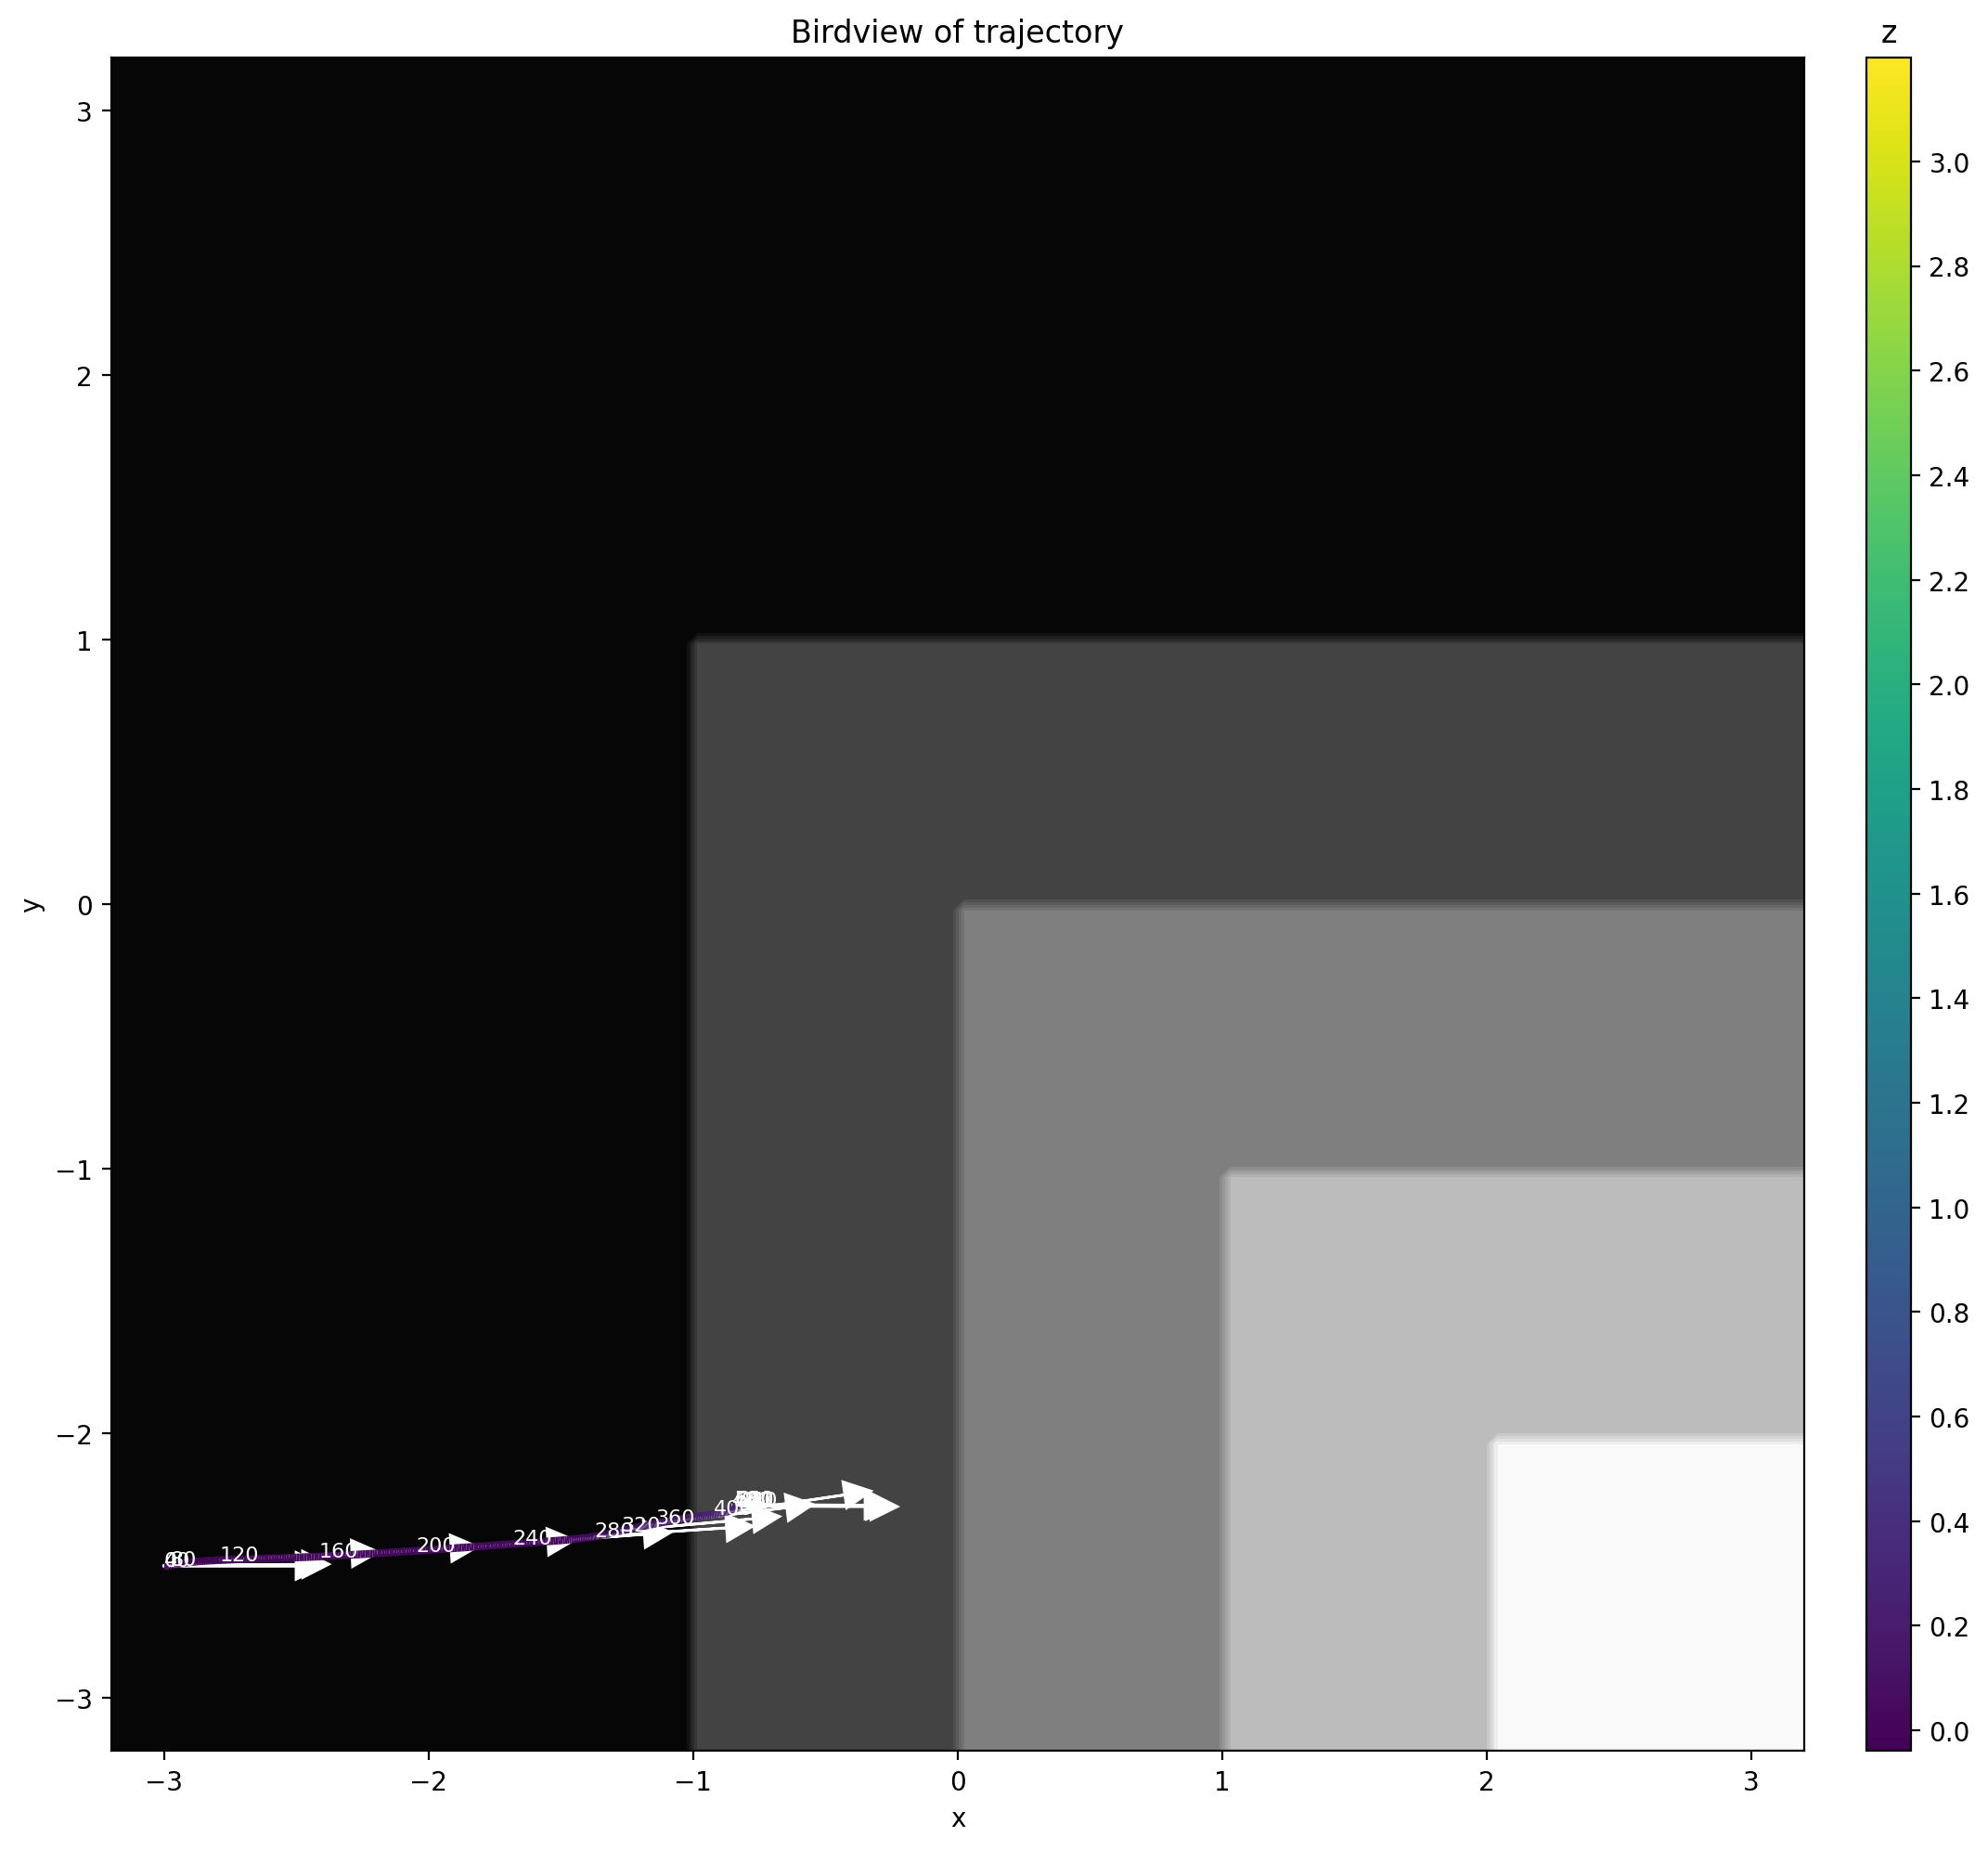

In [51]:
plot_birdview_trajectory(world_config, states, iter_step=40)

In [52]:
ROBOT_IDX = 0

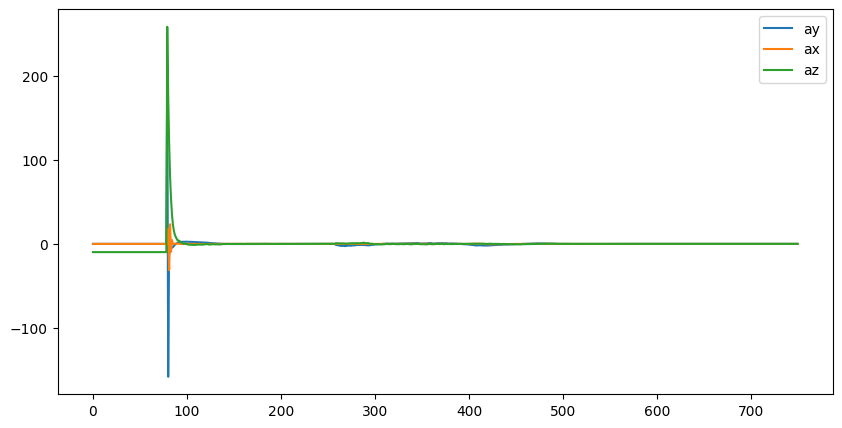

In [53]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(ay, label="ay")
plt.plot(ax, label="ax")
plt.plot(az, label="az")
plt.legend()

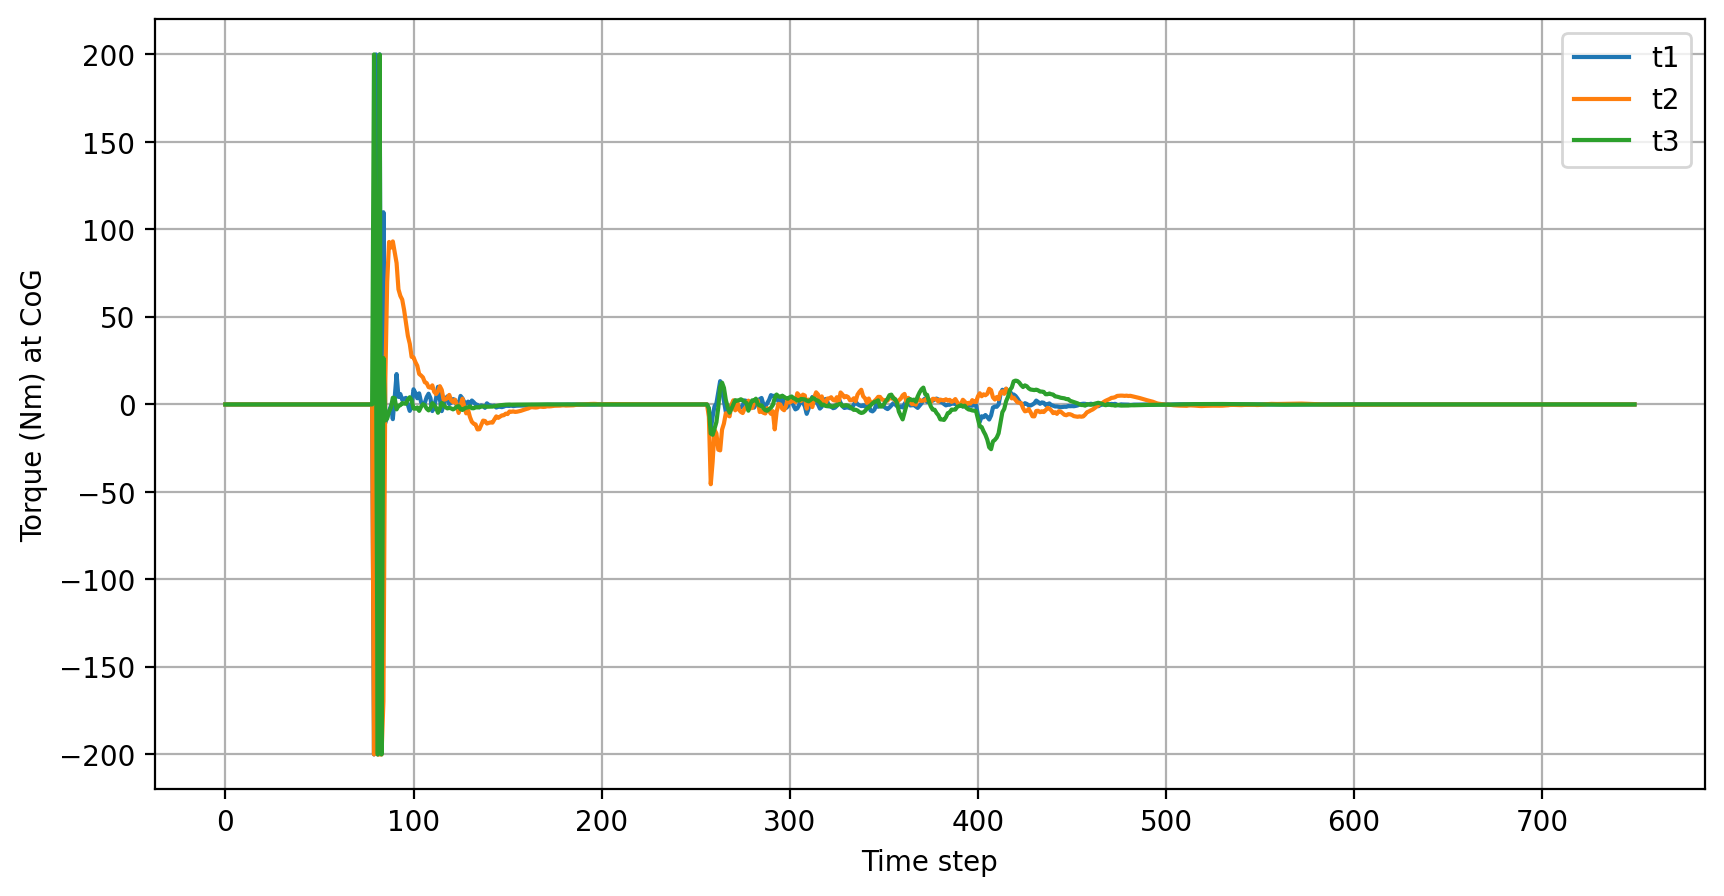

In [54]:
# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(t1, label="t1")
plt.plot(t2, label="t2")
plt.plot(t3, label="t3")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Torque (Nm) at CoG")
plt.legend()

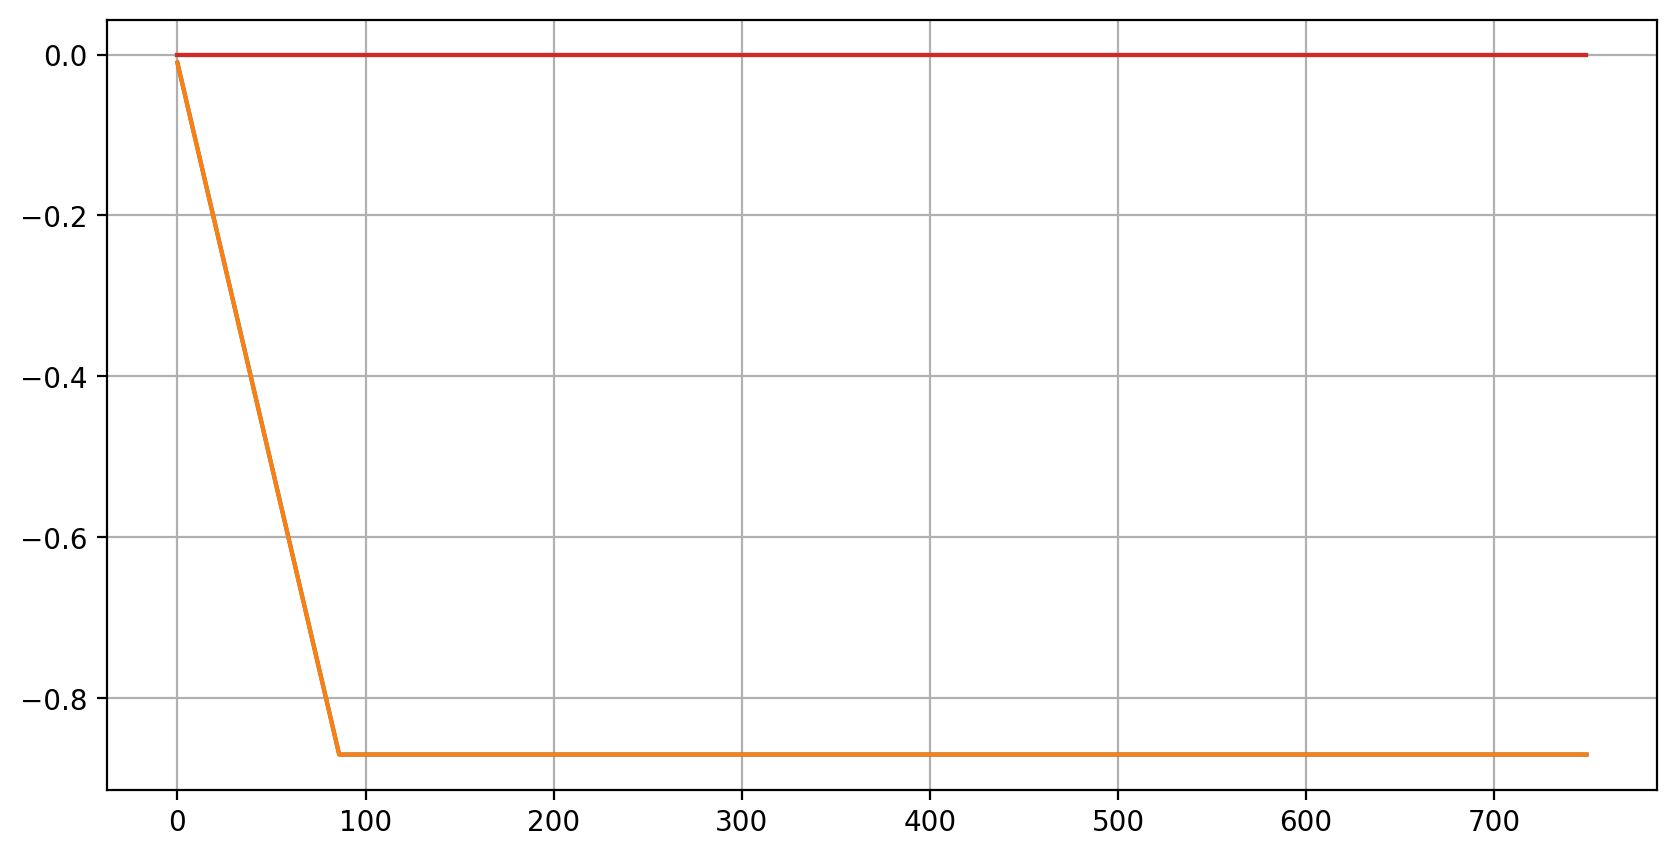

In [55]:
# Joint angles
plt.figure(figsize=(10, 5), dpi=200)
theta1, theta2, theta3, theta4 = states_vec.thetas[:, ROBOT_IDX].T.cpu().numpy()
plt.plot(theta1, label="theta1")
plt.plot(theta2, label="theta2")
plt.plot(theta3, label="theta3")
plt.plot(theta4, label="theta4")
plt.grid()

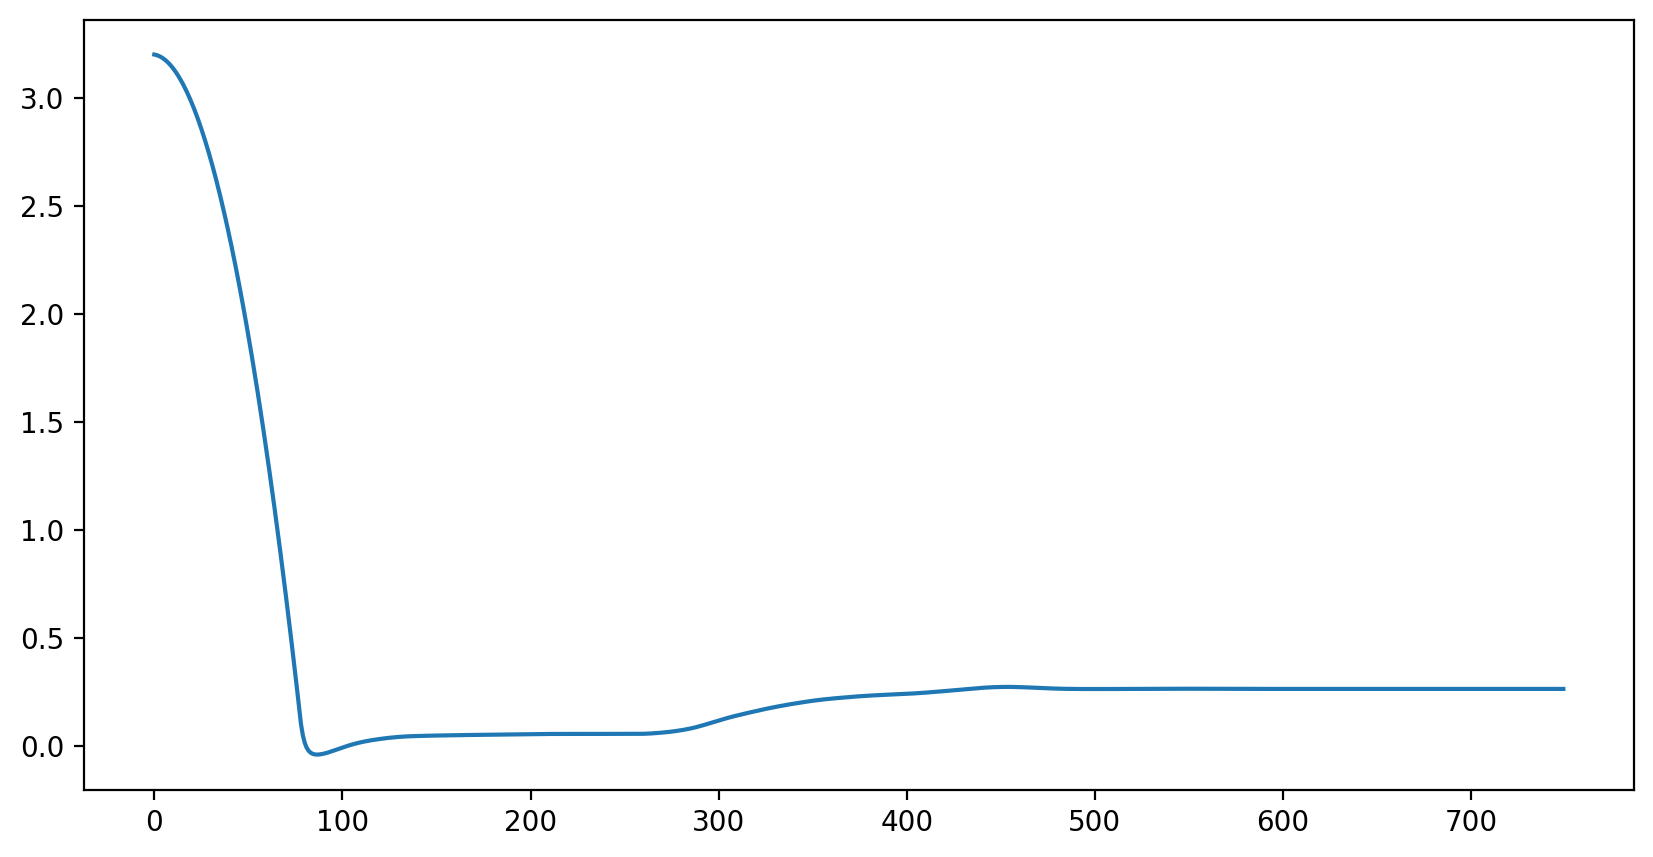

In [56]:
# Height of the robot
plt.figure(figsize=(10, 5), dpi=200)
z = states_vec.x[:, ROBOT_IDX, 2].cpu().numpy()
plt.plot(z)

In [57]:
plot_3d_trajectory(world_config, states, auxs)

In [58]:
SHOW_ANIMATION = True

In [60]:
if SHOW_ANIMATION:
    from flipper_training.vis.animator import animate_trajectory

    animate_trajectory(world_config, physics_config, states, auxs, ROBOT_IDX)

KeyboardInterrupt: 